In [3]:
using Pkg
Pkg.activate("Dev")
using Revise
using Skylight
using CairoMakie

  Activating project at `~/repos/Skylight.jl/run/Dev`


In [11]:
distance = 500
N = 400
spacetime = KerrSpacetimeBoyerLindquistCoordinates(M=1.0,a=0.5)
camera = PinholeCamera(position = [0.0, distance, π*(1/2-1/20), 0.0],
                        horizontal_aperture_in_degrees = rad2deg(atan(20/distance)),
                        vertical_aperture_in_degrees = rad2deg(atan(20/distance)),
                        horizontal_number_of_pixels = N,
                        vertical_number_of_pixels = N)
model = IonTorus(spacetime)
configurations = NonVacuumOTEConfigurations(spacetime=spacetime,
                                   camera = camera,
                                   radiative_model = model,
                                   unit_mass_in_solar_masses=1.0,
                                   observation_energies = [1e-17])
initial_data = initialize(configurations)
cb, cbp = callback_setup(configurations; rhorizon_bound=2e-1) #... or, define your own cb and cbp
run = integrate(initial_data, configurations, cb, cbp; method=VCABM(), reltol=1e-8, abstol=1e-8)
output_data = run.output_data

Equations integration stats:
Wall clock time: 456.981692373 seconds
Memory allocated: 130.418 GiB


10×160000 Matrix{Float64}:
 -1070.61        -1070.63        …  -1071.29        -1071.27
   550.0           550.0              550.0           550.0
     1.523           1.52162            1.9586          1.95704
    -3.35648        -3.3569             3.38001         3.37953
    -1.00164        -1.00164           -1.00164        -1.00164
     0.99767         0.997672    …      0.997672        0.99767
    -3.33147e-5     -3.33089e-5         3.06183e-5      3.0619e-5
    -3.26126e-5     -3.24535e-5         3.7778e-5       3.79197e-5
     0.0             0.0                0.0             0.0
     0.0             0.0                0.0             0.0

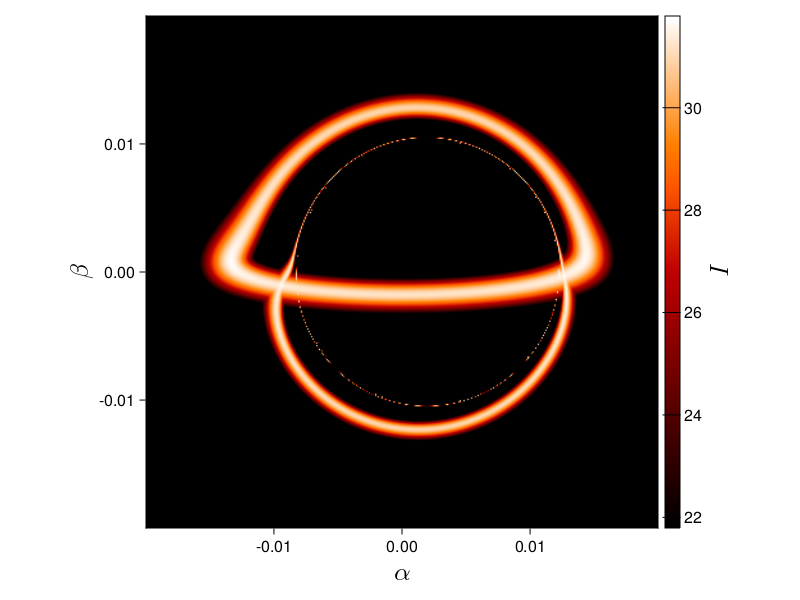

CairoMakie.Screen{IMAGE}


In [13]:
xs, ys = axes_ranges(camera) 
zs = grid_view(output_data, configurations; energy_index = 1)

zs[zs.<1e-40] .= 1e-40
zs = log10.(zs)
logzmin = minimum(zs[zs.>-40])
logzmax = maximum(zs)

fig = Figure(font = "CMU Serif") #resolution=(600,400)
ax = Axis(fig[1,1], xlabel=L"\alpha", ylabel=L"\beta", ylabelsize = 26, xlabelsize = 26) 
hmap = heatmap!(xs, ys, zs; colormap=:gist_heat, interpolate=true, colorrange=(logzmax-10, logzmax))
Colorbar(fig[:, end+1], hmap, label=L"I", labelsize=26, width = 15, ticksize = 18, tickalign = 1)
colsize!(fig.layout, 1, Aspect(1, 1.0))
colgap!(fig.layout, 7)
CairoMakie.save("plot.png", fig)
display(fig)

In [210]:
# position = camera.position
position = [0.0, model.rcenter, π/2, 0.0]
# Skylight.torus_normalized_potential(position, spacetime, model)
# Skylight.energy_density(position, spacetime, model)
ω = Skylight.torus_normalized_potential(position, spacetime, model)
ne, ni, Te = Skylight.number_densities_and_electron_temperature(ω, model)

(3.763837976289377e6, 4.892989369176191e6, 2.0000000000000026e9)

In [216]:
ε = exp10.(range(-19, stop=-6, length=61))
jε = map( ε -> Skylight.bremsstrahlung_emissivity(ε, ne, ni, Te), ε)

61-element Vector{Float64}:
 0.008902180393099328
 0.008756959064231655
 0.008611737735362739
 0.008466516406491825
 0.008321295077617676
 0.008176073748738293
 0.00803085241985046
 0.007885631090948973
 0.007740409762025435
 0.007595188433066312
 ⋮
 0.0012632428614765122
 0.00107965673334857
 0.0008842462956563259
 0.0006785873022576085
 0.00047051301033043414
 0.0002776344397460511
 9.934601011523297e-5
 2.5430857299204996e-5
 3.7231064852493814e-6

In [54]:
g = zeros(4,4)
v = zeros(4)
function norm_pot(r, spacetime, model, g)
    coords_top = coordinates_topology(spacetime)
    position = Skylight.equatorial_position(r, coords_top)
    metric!(g, position, spacetime)
    return Skylight.torus_normalized_potential(g, model)
end
function norm_pot(r, spacetime, model, g)
    coords_top = coordinates_topology(spacetime)
    position = Skylight.equatorial_position(r, coords_top)
    metric!(g, position, spacetime)
    return Skylight.torus_normalized_potential(g, model)
end
function is_inside_torus(r, spacetime, model, g)
    coords_top = coordinates_topology(spacetime)
    position = Skylight.equatorial_position(r, coords_top)
    metric!(g, position, spacetime)
    return Skylight.torus_normalized_potential(g, model) > 0.0
end
function is_rest_frame_timelike(r, spacetime, model, g, v)
    coords_top = coordinates_topology(spacetime)
    position = Skylight.equatorial_position(r, coords_top)
    metric!(g, position, spacetime)
    rest_frame_four_velocity!(v, position, g, spacetime, model, coords_top)
    return Skylight.is_timelike(v, g)
end

radii = model.rcusp:0.1:100.0

# tim = map(r -> is_rest_frame_timelike(r, spacetime, model, g, v), radii)
# pot = map(r -> is_inside_torus(r,spacetime,model,g), radii)
ωs = map(r -> norm_pot(r,spacetime,model,g), radii)
# rest_frame_energy = -scalar_product(vμ, momentum, metric)
# ε .= observation_energies*rest_frame_energy


967-element Vector{Float64}:
  0.0
  0.020056677381373983
  0.07000209670028344
  0.13805372882822478
  0.2160098732723615
  0.2981828866541206
  0.38066050435250265
  0.46078982013083847
  0.5368139037986773
  0.6076140612853751
  ⋮
 -6.212303909197357
 -6.213303006105102
 -6.214300180593548
 -6.215295438199383
 -6.21628878443814
 -6.217280224804127
 -6.218269764770735
 -6.219257409790418
 -6.220243165294795

In [127]:
radii = range(model.rcusp-1.0,model.rcusp, length=10)
# radii = range(model.rcusp, 1.63105*model.rcenter, length=10)
myf = Skylight.torus_normalized_potential
temp = map(r -> myf([0.0,r,0.0,0.0], spacetime, model), radii)

10-element Vector{Float64}:
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf

In [174]:
z_vals

200×200 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

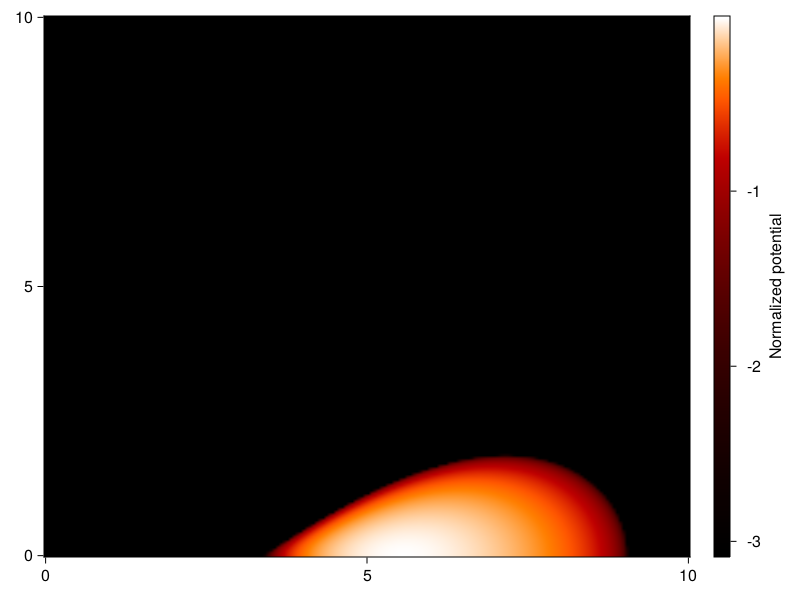

CairoMakie.Screen{IMAGE}


In [296]:
potential = (x, z) -> Skylight.torus_normalized_potential([0.0,sqrt(x^2+z^2),acos(z/sqrt(x^2+z^2)),0.0], spacetime, model)

size = 10
N = 200
x_vals = LinRange(0.0, size, N)
z_vals = LinRange(0.0, size, N)
w_vals = [potential(x, z) for x in x_vals, z in z_vals]

w_vals[w_vals .< 0.0] .= 1e-40 
wmin = minimum(w_vals[w_vals .> 1e-40])
wmax = maximum(w_vals)

fig = Figure()
ax = Axis(fig[1, 1])
img = heatmap!(x_vals, z_vals, log10.(w_vals), colormap=cmap, interpolate=true, colorrange=(log10(wmin), log10(wmax)))

cbar = Colorbar(fig[1, 2], img, label="Normalized potential", ticklabelpad=10) # contour!(ax, z_vals, levels=10, linewidth=1) # Adding contour lines

display(fig)

In [147]:
log10(NaN)

NaN

In [ ]:
torus_normalized_potential(g, model)